<a href="https://colab.research.google.com/github/Shridhara-kulal/CNN_Project/blob/main/Basic_Model_Without_using_TenserFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from skimage.transform import resize
from skimage.util import random_noise
from skimage import img_as_ubyte
import random


In [2]:
def load_images_from_folder(folder, image_size):
    images = []
    labels = []
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            filepath = os.path.join(subdir, file)
            image = Image.open(filepath)
            image = image.resize((image_size, image_size))
            image = np.array(image)
            if image.shape == (image_size, image_size, 3):  # Only add images with correct shape
                images.append(image)
                labels.append(os.path.basename(subdir))
    return np.array(images), np.array(labels)

IMAGE_SIZE = 256
data_dir = "/content/drive/MyDrive/PlantVillage"  # Update with your dataset path
images, labels = load_images_from_folder(data_dir, IMAGE_SIZE)
print(f"Loaded {len(images)} images.")


Loaded 2152 images.


Class Names: ['Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy']


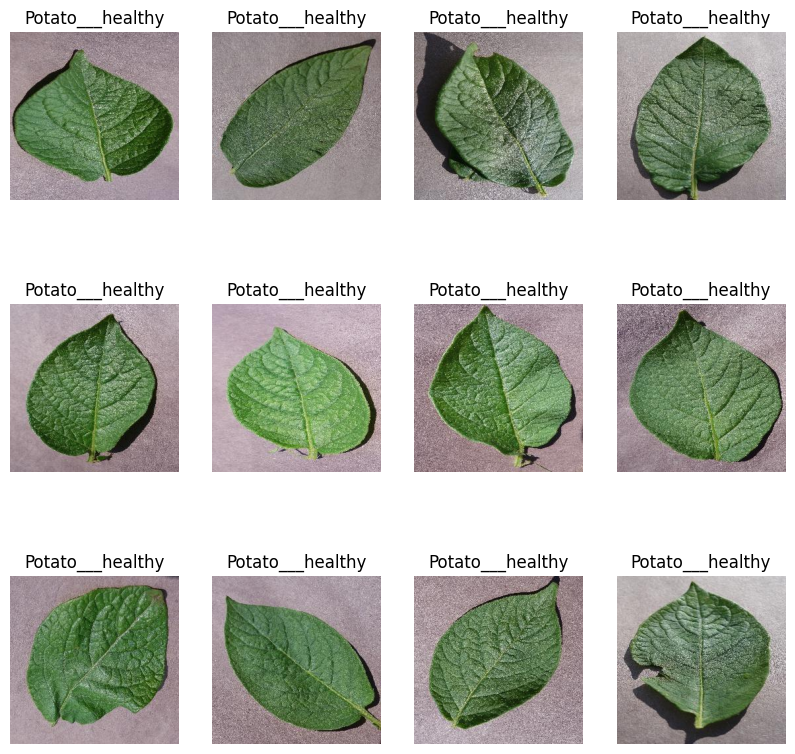

In [3]:
class_names = np.unique(labels)
print("Class Names:", class_names)

plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(labels[i])
    plt.axis("off")
plt.show()


In [4]:
def augment_image(image):
    # Randomly flip horizontally and vertically
    if random.random() > 0.5:
        image = np.fliplr(image)
    if random.random() > 0.5:
        image = np.flipud(image)

    # Random rotation
    angle = random.uniform(-30, 30)
    image = img_as_ubyte(resize(image, (IMAGE_SIZE, IMAGE_SIZE)))
    image = Image.fromarray(image)
    image = image.rotate(angle)
    image = np.array(image)

    # Random noise
    image = random_noise(image)
    image = np.clip(image, 0, 1)
    image = img_as_ubyte(image)
    return image

augmented_images = np.array([augment_image(image) for image in images])
print(f"Augmented {len(augmented_images)} images.")


Augmented 2152 images.


In [5]:
def preprocess_images(images, image_size):
    images = images.astype('float32') / 255.0
    images_resized = np.array([resize(image, (image_size, image_size)) for image in images])
    return images_resized

IMAGE_SIZE = 128  # Using smaller image size for quicker training
images_preprocessed = preprocess_images(augmented_images, IMAGE_SIZE)


In [6]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
X_train, X_temp, y_train, y_temp = train_test_split(images_preprocessed, labels_encoded, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")


Training samples: 1291, Validation samples: 430, Test samples: 431


In [7]:
from sklearn.svm import SVC

# Flatten the images for the SVM classifier
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat = X_val.reshape(len(X_val), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# Standardize the data
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)
X_test_flat = scaler.transform(X_test_flat)

# Train SVM classifier
svm_clf = SVC(kernel='linear', probability=True)
svm_clf.fit(X_train_flat, y_train)


SVC(kernel='linear', probability=True)

In [8]:
y_val_pred = svm_clf.predict(X_val_flat)
y_test_pred = svm_clf.predict(X_test_flat)

val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Validation Accuracy: {val_accuracy}")
print(f"Test Accuracy: {test_accuracy}")


Validation Accuracy: 0.9116279069767442
Test Accuracy: 0.8979118329466357


In [9]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[162  18   0]
 [ 13 209   1]
 [  1  11  16]]


In [12]:
def preprocess_images_for_display(images):
    # Since images were scaled to [0, 1], we scale them back to [0, 255] and convert to uint8
    images = (images * 255).astype(np.uint8)
    return images

X_test_display = preprocess_images_for_display(X_test)


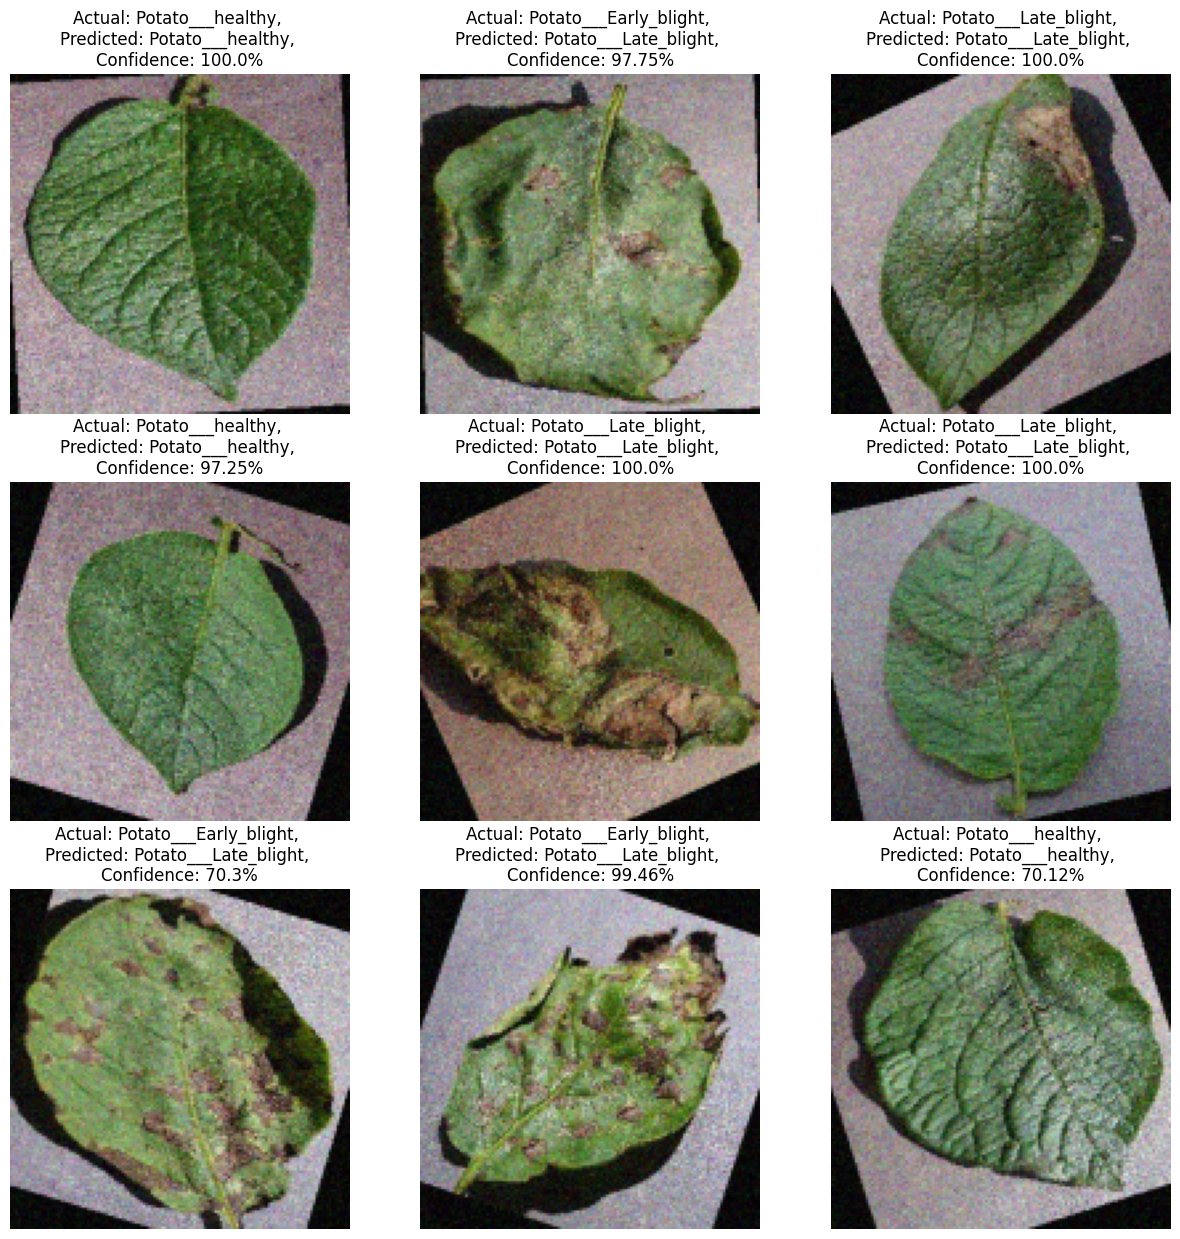

In [16]:
def predict(model, img, scaler):
    img_flat = img.reshape(1, -1)
    img_flat = scaler.transform(img_flat)
    predictions = model.predict_proba(img_flat)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test_display[i])  # Use the correctly scaled image for display

    predicted_class, confidence = predict(svm_clf, X_test_flat[i], scaler)
    actual_class = class_names[y_test[i]]

    plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
    plt.axis("off")

plt.show()


<Figure size 1500x1500 with 0 Axes>

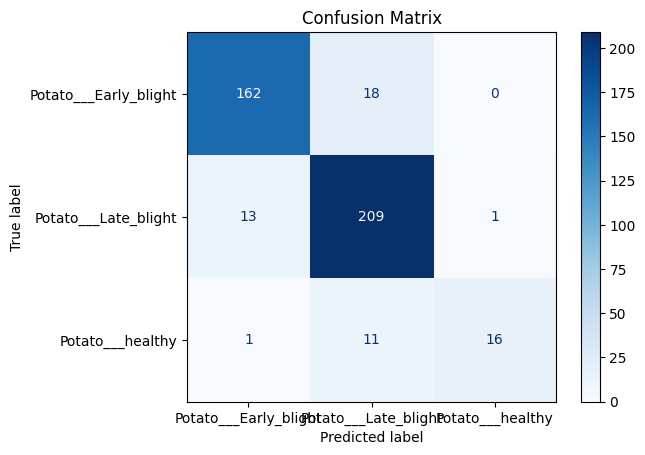

In [19]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
y_pred = svm_clf.predict(X_test_flat)
cm = confusion_matrix(y_test, y_pred, labels=range(len(class_names)))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


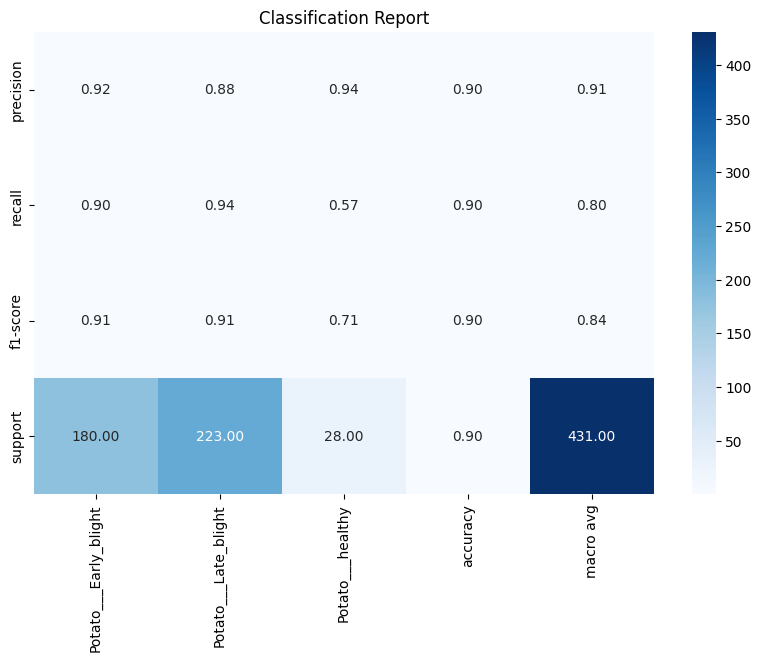

In [21]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate classification report
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot classification report
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report")
plt.show()
